# Train, test, export model for Electricty monitor IDS 

Datasets is from personal usage documentation
<br> <br>
Clustered with unsupervised algorithm - Isolation Foreset
<br>
Feature classifying/learning with supervised algorithm - Random Forest

## Config

### Import

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime
import joblib

from tabulate import tabulate

from sqlalchemy import create_engine, Column, Integer, Float, String, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, declarative_base

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, make_scorer, accuracy_score, precision_score, f1_score
from sklearn.utils import resample  
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

### database config

In [23]:
# Configure database connection
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': '',
    'database': 'db_esp32'
}

In [24]:
# Create engine and session
engine = create_engine('mysql+mysqlconnector://root:@localhost/db_esp32')
Session = sessionmaker(bind=engine)
session = Session()

# Create the Base class
Base = declarative_base()

# Define the ElectricityMonitor class
class ElectricityMonitor(Base):
    __tablename__ = 'electricity_monitor'  # Use your actual table name here
    data_id = Column(Integer, primary_key=True)
    device_id = Column(String(255))
    voltage = Column(Float)
    current = Column(Float)
    power = Column(Float)
    energy = Column(Float)
    frequency = Column(Float)
    power_factor = Column(Float)
    created_at = Column(DateTime)

In [25]:
# Fetch data from the database with only power > 0 and order by created_at in descending order
def fetch_data():
    query = session.query(ElectricityMonitor).where(ElectricityMonitor.power > 0.5).order_by(ElectricityMonitor.created_at.desc())
    df = pd.read_sql(query.statement, query.session.bind)
    return df

def get_deviceId():
    query = session.query(ElectricityMonitor.device_id).distinct()
    device_ids = pd.read_sql(query.statement, query.session.bind)
    return device_ids

df = fetch_data()
device_ids = get_deviceId()

print(df.count())

data_id         33868
device_id       33868
voltage         33868
current         33868
power           33868
energy          33868
frequency       33868
power_factor    33868
created_at      33868
dtype: int64


## Pre-processing

### Load the datasets

In [26]:
print('Count: \n', df.count())
print('\ndatasets: \n', df.head())
print('\n')
print('device_ids: \n', device_ids)

Count: 
 data_id         33868
device_id       33868
voltage         33868
current         33868
power           33868
energy          33868
frequency       33868
power_factor    33868
created_at      33868
dtype: int64

datasets: 
    data_id          device_id  voltage  current  power  energy  frequency  \
0   202729  D4:8A:FC:60:47:60    191.6    0.070    6.8   1.317       50.0   
1   202728  D4:8A:FC:60:47:60    191.7    0.069    6.8   1.317       50.0   
2   202727  D4:8A:FC:60:47:60    190.1    0.069    6.8   1.317       50.0   
3   202726  D4:8A:FC:60:47:60    189.7    0.069    6.8   1.317       50.0   
4   202725  D4:8A:FC:60:47:60    187.3    0.070    6.8   1.317       50.0   

   power_factor          created_at  
0          0.51 2024-07-27 20:16:54  
1          0.51 2024-07-27 20:16:49  
2          0.52 2024-07-27 20:16:44  
3          0.52 2024-07-27 20:16:39  
4          0.52 2024-07-27 20:16:34  


device_ids: 
            device_id
0  D4:8A:FC:60:47:60


#### Handling missing values

In [27]:
print("before:\n\n", df.isnull().sum())
# Fill missing values with median
df['voltage'].fillna(df['voltage'].median())

# Fill device_id with the latest id
latest_id = device_ids['device_id'].iloc[-1]
df['device_id'].fillna(latest_id)

# Fill created_at with current date and time
df['created_at'].fillna(pd.to_datetime('now'))

print("\n\nafter:\n", df.isnull().sum())

before:

 data_id         0
device_id       0
voltage         0
current         0
power           0
energy          0
frequency       0
power_factor    0
created_at      0
dtype: int64


after:
 data_id         0
device_id       0
voltage         0
current         0
power           0
energy          0
frequency       0
power_factor    0
created_at      0
dtype: int64


## Model Training

### Split dataset for training and testing

In [28]:
train_df, test_df = train_test_split(df, test_size=0.33, random_state=42)

print(train_df.count())

data_id         22691
device_id       22691
voltage         22691
current         22691
power           22691
energy          22691
frequency       22691
power_factor    22691
created_at      22691
dtype: int64


In [29]:
# Inspect the distribution of the power feature
print("Power Distribution in Training Data:")
print(train_df['power'].describe())

Power Distribution in Training Data:
count    2.269100e+04
mean     9.222178e+03
std      1.386926e+06
min      6.000000e-01
25%      6.800000e+00
50%      1.610000e+01
75%      1.740000e+01
max      2.089200e+08
Name: power, dtype: float64


### Unsupervised Learning - Isolation Forest

### Train and predict 

In [30]:
def train_if():
    for device_id in device_ids['device_id']:
        features = ['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']
        # Train model
        if_model = IsolationForest(contamination=0.1, random_state=42)
        if_model.fit(train_df[train_df['device_id'] == device_id][features])

        # Predict Label
        df.loc[df['device_id'] == device_id, 'if_label'] = if_model.predict(df[df['device_id'] == device_id][features])
        
        # Explicitly cast the 'if_label' column to string type right after prediction
        df['if_label'] = df['if_label'].astype(str)
        df.loc[df['device_id'] == device_id, 'if_label'] = np.where(df.loc[df['device_id'] == device_id, 'if_label'] == '1.0', 'normal', 'anomaly')

        # print(df.head())
        print(df.value_counts('if_label'))
        # filename = f'if_model_{device_id.replace(":", "-")}.pkl'
        # joblib.dump(if_model, filename)
        
train_if()

if_label
normal     30444
anomaly     3424
Name: count, dtype: int64


### Show results for rows that have normal label

In [31]:
for device_id in device_ids['device_id']:
    print(df[df['device_id'] == device_id].value_counts('if_label'))


if_label
normal     30444
anomaly     3424
Name: count, dtype: int64


In [32]:
# testing apakah power di atas 20 watt ada yang normal
for device_id in device_ids['device_id']:
    print(df[(df['power'] > 20) & (df['device_id'] == device_id) & (df['if_label'] != 'anomaly')])



       data_id          device_id  voltage   current  power  energy  \
453     202276  D4:8A:FC:60:47:60    201.1  0.170000   20.8   1.309   
454     202275  D4:8A:FC:60:47:60    201.1  0.171000   20.8   1.309   
455     202274  D4:8A:FC:60:47:60    200.8  0.171000   20.8   1.309   
456     202273  D4:8A:FC:60:47:60    200.6  0.171000   20.8   1.309   
457     202272  D4:8A:FC:60:47:60    202.3  0.169000   20.7   1.309   
...        ...                ...      ...       ...    ...     ...   
33838     8188  D4:8A:FC:60:47:60    210.5  0.162001   20.1   1.033   
33839     8187  D4:8A:FC:60:47:60    209.3  0.163000   20.1   1.033   
33840     8186  D4:8A:FC:60:47:60    209.2  0.163000   20.1   1.033   
33843     8183  D4:8A:FC:60:47:60    209.9  0.162001   20.1   1.033   
33845     8181  D4:8A:FC:60:47:60    210.2  0.162001   20.1   1.033   

       frequency  power_factor          created_at if_label  
453         50.0          0.61 2024-07-27 19:39:09   normal  
454         50.0       

### Show results for rows that have anomaly label

In [33]:
# testing apakah power di atas 17 di bawah 20 watt ada yang anomaly
print(df[(df['if_label'] != 'normal') & (df['power'] > 17) & (df['power'] < 20)].head(10))


       data_id          device_id  voltage  current  power  energy  frequency  \
6362    180424  D4:8A:FC:60:47:60    185.9    0.149   17.1   1.203       49.9   
10749   167816  D4:8A:FC:60:47:60    213.9    0.171   19.5   1.074       49.9   
10751   167814  D4:8A:FC:60:47:60    214.2    0.173   19.6   1.074       49.9   
12252   165234  D4:8A:FC:60:47:60    186.3    0.147   17.3   1.008       49.9   
26549    68723  D4:8A:FC:60:47:60    215.5    0.147   19.7   0.602       49.9   
28236    59065  D4:8A:FC:60:47:60    192.8    0.169   19.2   0.075       49.9   
28239    59061  D4:8A:FC:60:47:60    193.6    0.148   17.4   0.075       49.9   
28240    59060  D4:8A:FC:60:47:60    192.9    0.150   17.7   0.075       49.9   
30179    48315  D4:8A:FC:60:47:60    193.6    0.147   17.6   0.029       49.9   
31417    47076  D4:8A:FC:60:47:60    206.7    0.150   19.4   0.020       49.9   

       power_factor          created_at if_label  
6362           0.62 2024-07-22 17:19:31  anomaly  
10749 

## Supervised Learning - Random Forest

Label distribution for device D4:8A:FC:60:47:60:
if_label
normal     30444
anomaly     3424
Name: count, dtype: int64
voltage: 0.08366157437000096
current: 0.2771043105165553
power: 0.23502673583682157
energy: 0.07621940378962329
frequency: 0.06309924351108527
power_factor: 0.2648887319759136


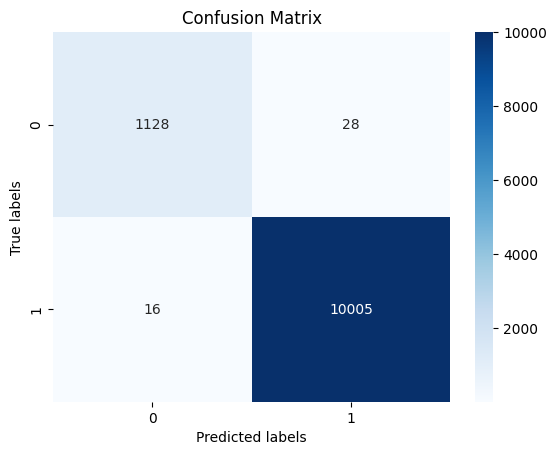

╒══════════╤════════════╤════════════╤═════════════╤══════════╕
│ Metric   │   Accuracy │   F1 Score │   Precision │   Recall │
╞══════════╪════════════╪════════════╪═════════════╪══════════╡
│ Value    │   0.996063 │   0.996054 │    0.996051 │ 0.996063 │
╘══════════╧════════════╧════════════╧═════════════╧══════════╛


In [34]:
import tabulate as tabulate
def train_rf():
    for device_id in device_ids['device_id']:
        features = ['voltage', 'current', 'power', 'energy', 'frequency', 'power_factor']
        X = df[df['device_id'] == device_id][features]
        y = df[df['device_id'] == device_id]['if_label']
        label_counts = y.value_counts()
        print(f"Label distribution for device {device_id}:")
        print(label_counts)
        # Ensure there is data to train on
        if not X.empty and not y.empty:
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            # Splitting the dataset
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

            # Training a Random Forest Classifier
            rf_model.fit(X_train, y_train)

            # Getting feature importances
            feature_importances = rf_model.feature_importances_

            # Printing feature importances
            for feature, importance in zip(X.columns, feature_importances):
                print(f"{feature}: {importance}")

            # Make predictions on the test set
            y_pred = rf_model.predict(X_test)

            # Generate the confusion matrix
            conf_matrix = confusion_matrix(y_test, y_pred)

            # Visualize the confusion matrix (Optional)
            sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
            plt.xlabel('Predicted labels')
            plt.ylabel('True labels')
            plt.title('Confusion Matrix')
            plt.show()
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            table = [['Metric', 'Value'],
                ['Accuracy', accuracy],
                ['F1 Score', f1],
                ['Precision', precision],
                ['Recall', recall]]
            # Transpose the table
            transposed_table = list(zip(*table))
            # Print the transposed table
            print(tabulate.tabulate(transposed_table, headers='firstrow', tablefmt='fancy_grid'))
            
            # filename = f'rf_model_{device_id.replace(":", "-")}.pkl'
            # joblib.dump(rf_model, filename)
        else:
            print(f"No data available for device {device_id}, skipping...")

train_rf()